# Python: mini-project 6.1

# Task
Here is the data of interactions with advertisements on a certain site for 6 days. And a table with the characteristics of advertising clients (those who posted these ads).

1. Let's deal with the distribution of the number of impressions and clicks. Calculate the average number of impressions and the average number of clicks on ads for the entire period (round up to integers).
2. Draw a graph of the distribution of impressions per ad for the entire period.
3. Let's calculate the moving average of impressions with a window 2. What is the moving average value for April 6, 2019 (round the answer to integers)?
4. Moving average is often used to find anomalies in data. Let's try to plot the values ​​of the arithmetic average by days and the moving average of the number of impressions on one chart. On which day is the greatest difference in modulus between the arithmetic average and the moving average? Days in which the moving average is equal to NaN are not taken into account.
5. *Write a function that will find the problematic ad (with the highest/least impressions) on the day that the largest anomaly was seen modulo.
6. Now let's load the data on advertising clients and find the average number of days from the date of creation of an advertising client and the first launch of an advertisement by this client.
7. Calculate the conversion from ad client creation to first ad launch within a maximum of 365 days. Give your answer as a percentage and round to the nearest hundredth. (You need to filter by value in the format pd.Timedelta(365, unit='d'))
8. Let's break down our customers by ad creation to ad launch time of 30. Determine how many unique customers launched their first ad in the first month of their existence (0 to 30 days). Range list for pd.cut method - [0, 30, 90, 180, 365]
9. And now - we will display these categories on an interactive chart with the number of unique customers in them.

### Data Description
1. ads_data.csv - ad interaction data

- date - date
- time - time
- event - action (view/click)
-platform - platform
- ad_id - ad id
- client_union_id - id of the advertising account
- campaign_union_id - advertising campaign id
- ad_cost_type - payment type
- ad_cost - price
- has_video - is there a video
- target_audience_count - audience size

2. ads_clients_data.csv - characteristics of advertising clients

- date - date
- client_union_id - id of the advertising account
- community_id - community id
- create_date – ad client creation date

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
ads_data = pd.read_csv('./ads_data.csv', parse_dates=['date', 'time'])

In [4]:
ads_clients_data = pd.read_csv('./ads_clients_data.csv')
ads_clients_data.dtypes

date               object
client_union_id     int64
community_id        int64
create_date        object
dtype: object

In [5]:
ads_clients_data = pd.read_csv('./ads_clients_data.csv', parse_dates=['date'])
ads_clients_data.dtypes

date               datetime64[ns]
client_union_id             int64
community_id                int64
create_date                object
dtype: object

In [6]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [7]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08



First, let's calculate the average number of different advertising events (impressions and clicks) for ads. A subtle point: remember that some displayed ads were not clicked, and when grouping in such cases there will be no rows with clicks, and they must be taken into account to calculate the average for ads. Round your answers to whole numbers.

In [8]:
event_count = ads_data.groupby(['ad_id', 'event'], as_index=False).size()
event_count

,ad_id,event,size
0,2,click,1
1,2,view,101
2,3,click,3
3,3,view,184
4,1902,click,1
...,...,...,...
1476,122013,view,156
1477,122023,view,68
1478,122031,click,1
1479,122031,view,138


In [9]:
#create pivot-table
event_count_pivot = event_count.pivot(index='ad_id', columns='event', values='size')
event_count_pivot.head()

event,click,view
ad_id,,
2,1.0,101.0
3,3.0,184.0
1902,1.0,41.0
2064,NaN,35.0
2132,1.0,58.0


In [10]:
event_count_pivot = event_count_pivot.fillna(0)
event_count_pivot

event,click,view
ad_id,,
2,1.0,101.0
3,3.0,184.0
1902,1.0,41.0
2064,0.0,35.0
2132,1.0,58.0
...,...,...
122004,4.0,100.0
122013,0.0,156.0
122023,0.0,68.0


In [11]:
event_count_pivot.mean().round()

event
click    113.0
view     923.0
dtype: float64

# Task 2
Let's look at the distribution of ad impressions!

- On the x-axis - the number of impressions
- On the y-axis - the share of ads with such impressions
Take the logarithm of the number of impressions, and then build a graph so that you can understand the shape of the distribution.

In [12]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [13]:
view = ads_data.loc[ads_data.event == 'view'].ad_id.value_counts()
view.head()

112583    351802
107729    184596
107837     51996
28142      24152
45008      19668
Name: ad_id, dtype: int64

In [14]:
log_view = np.log(ads_data.loc[ads_data.event == 'view'].ad_id.value_counts())
log_view.head()

112583    12.770824
107729    12.125925
107837    10.858922
28142     10.092122
45008      9.886748
Name: ad_id, dtype: float64

<Axes: xlabel='ad_id', ylabel='Density'>

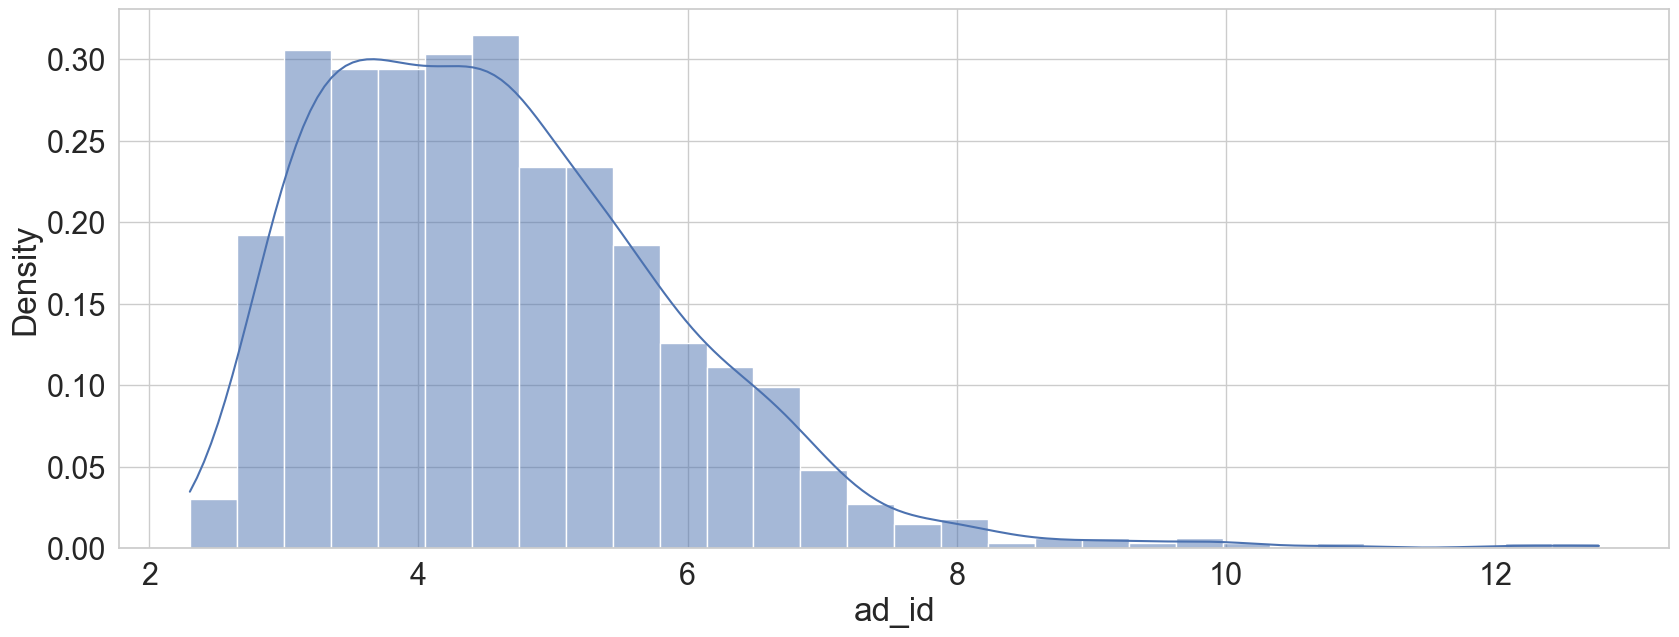

In [15]:
sns.histplot(data=log_view, kde=True, stat='density')


# Task 3
Now we need to find the average number of impressions per 1 ad (ad_id) by day, ignoring ads that had no impressions (normal average). After that, calculate the moving average of the result obtained with a window of 2 elements.

Question: What is the value of the moving average for April 6, 2019? Round your answer to the nearest whole number.

In [16]:
daily_views = ads_data.loc[ads_data.event == 'view'].pivot_table(index='ad_id', 
                                                                 columns='date',
                                                                 values='time',
                                                                 aggfunc='count')

In [17]:
daily_views.head()

date,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06
ad_id,,,,,,
2,83.0,18.0,NaN,NaN,NaN,NaN
3,158.0,26.0,NaN,NaN,NaN,NaN
1902,NaN,NaN,34.0,7.0,NaN,NaN
2064,NaN,28.0,7.0,NaN,NaN,NaN
2132,NaN,NaN,25.0,27.0,6.0,NaN


In [18]:
mean_views = daily_views.mean()
mean_views 

date
2019-04-01    154.482270
2019-04-02    137.786982
2019-04-03    163.952778
2019-04-04    675.901720
2019-04-05    919.109677
2019-04-06    277.122727
dtype: float64

In [19]:
roll_views = daily_views.mean().rolling(window=2).mean().round(0)
roll_views

date
2019-04-01      NaN
2019-04-02    146.0
2019-04-03    151.0
2019-04-04    420.0
2019-04-05    798.0
2019-04-06    598.0
dtype: float64

# Task 4

The moving average is often used to find anomalies in data. Let's try to plot on one graph the values ​​of just the average number of impressions by day and the moving average based on this data (which we received in the last task).

Calculate on which day there is the greatest difference in modulus between the arithmetic average and the moving average? Days in which the moving average is equal to NaN are not taken into account. Write the answer in the format yyyy-MM-dd

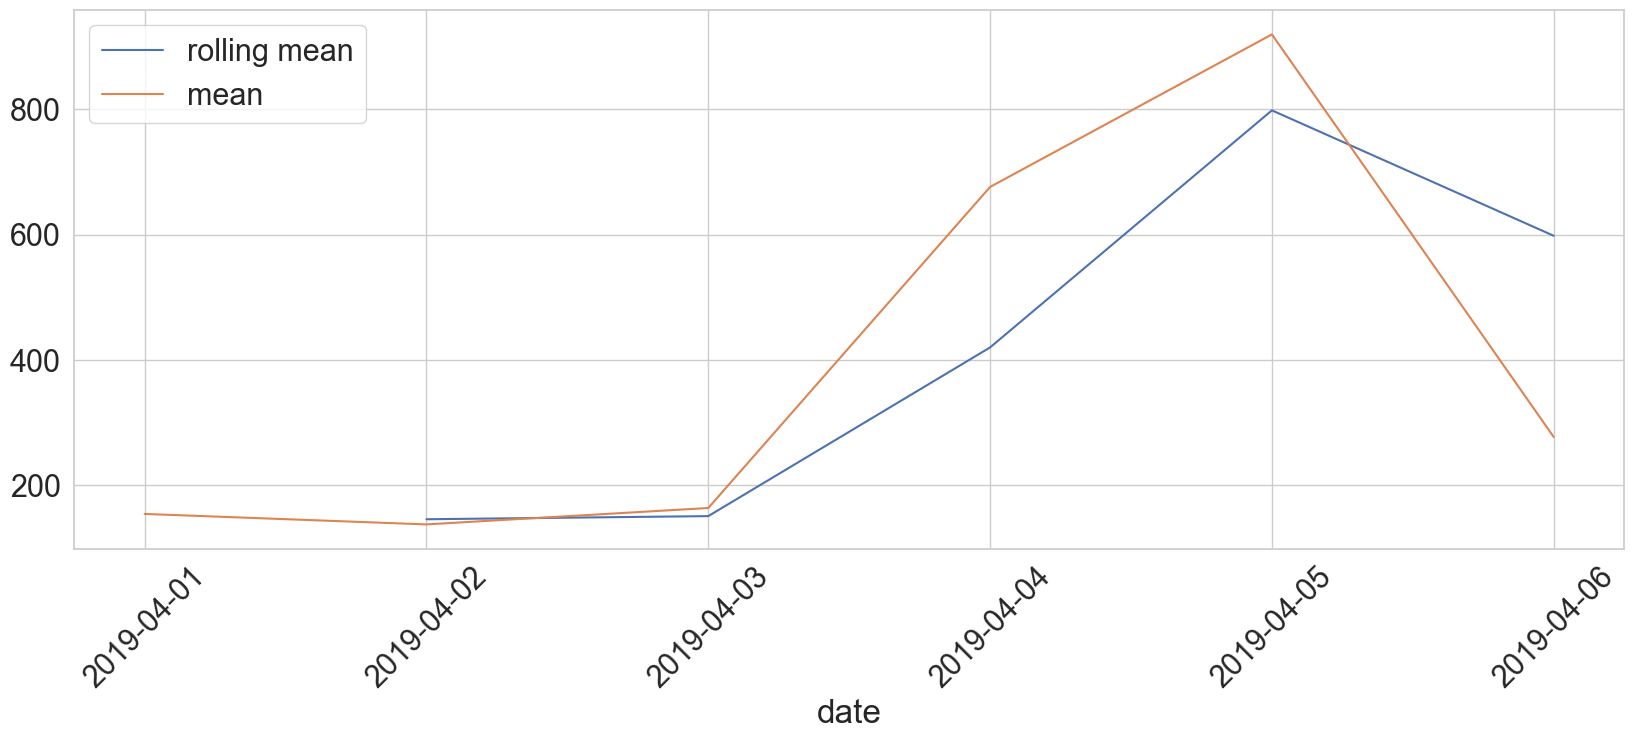

In [20]:
fig, ax = plt.subplots()
sns.lineplot(data=roll_views, ax=ax, label='rolling mean')
sns.lineplot(data=mean_views, ax=ax, label='mean')
ax.tick_params(axis='x', rotation=45)
plt.legend()

In [21]:
(mean_views - roll_views).abs().idxmax()

Timestamp('2019-04-06 00:00:00')

In [22]:
mean_views.subtract(roll_views) \
          .abs() \
          .idxmax()

Timestamp('2019-04-06 00:00:00')


Answer: 2019-04-06 there is the largest difference in modulus between the arithmetic average and the moving average

# Task 6
Combine the ad data with the ad client data and find the average number of days from the date the ad client was created (create_date) and the ad client was first run (date).

Enter the average number of days as your answer.


In [23]:
general = ads_clients_data.merge(ads_data, on=['client_union_id'], suffixes=('_client_data', '_ad_data'))

In [24]:
general.head()

,date_client_data,client_union_id,community_id,create_date,date_ad_data,time,event,platform,ad_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:08:51,view,android,3,1,CPC,46.7,0,45035
1,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:09:36,view,ios,3,1,CPC,46.7,0,45035
2,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:29:30,view,ios,3,1,CPC,46.7,0,45035
3,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:29:58,view,android,3,1,CPC,46.7,0,45035
4,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:51:54,view,android,3,1,CPC,46.7,0,45035


In [25]:
general.dtypes

date_client_data         datetime64[ns]
client_union_id                   int64
community_id                      int64
create_date                      object
date_ad_data             datetime64[ns]
time                     datetime64[ns]
event                            object
platform                         object
ad_id                             int64
campaign_union_id                 int64
ad_cost_type                     object
ad_cost                         float64
has_video                         int64
target_audience_count             int64
dtype: object

In [26]:
general.create_date = pd.to_datetime(general.create_date)

In [27]:
general \
    .groupby('client_union_id') \
    .apply(lambda group: (group.date_ad_data - group.create_date).min()) \
    .mean()

Timedelta('124 days 09:04:43.532219570')

# Task 6

Let's calculate the conversion from the creation of an advertising account to the launch of the first ad within no more than 365 days.

Conversion is the ratio of the number of customers who completed the target action (created ads) to the total number of customers.

To select data for the required period, you can use the comparison of the time before the creation of the first advertisement with pd.Timedelta(365, unit='day')

In [28]:
threshold = pd.to_timedelta(365, unit='d')
threshold

Timedelta('365 days 00:00:00')

In [29]:
creation_diff = general \
    .groupby('client_union_id') \
    .apply(lambda group: (group.date_ad_data - group.create_date).min())

In [30]:
creation_diff = creation_diff.loc[creation_diff < threshold]

In [31]:
round(creation_diff.shape[0] / ads_clients_data.client_union_id.nunique() * 100, 2)

0.69

# Task 7

Let's break down our clients by intervals from the creation of an advertising account to the launch of the first advertisement.

Determine how many unique customers launched their first ad in their first month of existence (0 to 30 days). The list of day intervals for the pd.cut() method is [0, 30, 90, 180, 365]. Time periods can be created using pd.to_timedelta().

In [32]:
bins = pd.to_timedelta([0, 30, 90, 180, 365], unit='d')

In [33]:
creation_dif_group = pd.cut(creation_diff, 
                               bins=bins,
                               labels=['0-30', '30-90', '90-180', '180-365'])

In [34]:
creation_dif_group.value_counts()

90-180     396
30-90      263
180-365    168
0-30        11
dtype: int64

In [35]:
px.bar(creation_dif_group.value_counts())